In [1]:
from google.colab import auth
auth.authenticate_user()

!gcloud config set project clever-aleph-203411

Updated property [core/project].


In [0]:
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/datasetv5.h5 dataset.h5

Copying gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/datasetv5.h5...
\ [1 files][  2.1 GiB/  2.1 GiB]   64.1 MiB/s                                   
Operation completed over 1 objects/2.1 GiB.                                      


In [0]:
!mkdir models

In [2]:
import keras
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import h5py

Using TensorFlow backend.


In [0]:
f = h5py.File('dataset.h5', 'r')
x_train = f['x_train'][:]
y_train = f['y_train'][:]
x_test = f['x_test'][:-1300]
y_test = f['y_test'][:-1300]
f.close()

In [0]:
with h5py.File('dataset.h5', 'r') as f:
  x = f['x'][:]
  y = f['y'][:]
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
  del x
  del y

In [0]:
batch_size = 32
epochs = 300

In [0]:
class SaveModel(Callback):
    def __init__(self, period=10):
        self.filepath = "/content/models/dbp-{epoch:02d}-{val_loss:.2f}.h5"
        self.gcsfile = "gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v12/dbp-{epoch:02d}-{val_loss:.2f}.h5"
        self.loss = None
        self.old_epoch = 0
        self.period = period
        
    def on_train_begin(self, logs={}):
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if(self.loss == None):
            self.loss = logs.get('val_loss')
            return
        else:
            if(self.loss > logs.get('val_loss') and (epoch-self.old_epoch)>self.period):
                self.old_epoch = epoch
                filepath = self.filepath.format(epoch=epoch + 1, **logs)
                gcsfile = self.gcsfile.format(epoch=epoch + 1, **logs)
                self.model.save_weights(filepath, overwrite=True)
                !gsutil cp {filepath} {gcsfile}
            self.loss = logs.get('val_loss')
            return

In [0]:
model = Sequential()
model.add(Conv2D(4, (3, 4), input_shape=(48, 640, 1), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Conv2D(8, (3, 4), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(16, (3, 8), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Conv2D(32, (3, 8), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 16), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Conv2D(128, (3, 16), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(2, activation='linear'))

In [0]:
model = Sequential()
model.add(Conv2D(4, (3, 2), input_shape=(48, 640, 1), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(8, (3, 4), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(16, (3, 8), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 16), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',  moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dense(2, activation='linear'))

In [0]:
model.summary()

In [0]:
# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = keras.optimizers.RMSprop(lr=0.001)

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
#sm = SaveModel()
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)

In [0]:
model_json = model.to_json()
with open("/content/models/model.json", "w") as json_file:
    json_file.write(model_json)
!gsutil cp '/content/models/model.json' 'gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v12-bn/sbp_model-zp.json'
print(model_json)

Copying file:///content/models/model.json [Content-Type=application/json]...
/ [1 files][ 11.2 KiB/ 11.2 KiB]                                                
Operation completed over 1 objects/11.2 KiB.                                     
{"class_name": "Sequential", "config": {"name": "sequential_4", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_9", "trainable": true, "batch_input_shape": [null, 48, 640, 1], "dtype": "float32", "filters": 4, "kernel_size": [2, 4], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", 

ascending order conv layers

In [0]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, verbose=1, callbacks=[es, rp])
with open('models/history.pickle', 'wb') as f:
  pickle.dump(history, f)
!gsutil cp '/content/models/history.pickle' 'gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v04/history01.pickle'
model.save('/content/models/best.h5')
!gsutil cp '/content/models/best.h5' 'gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v04/model01.h5'

In [3]:
!gsutil cp -r gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v02 /content

Copying gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v02/history01.pickle...
Copying gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v02/history02.pickle...
Copying gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v02/model01.h5...
Copying gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/models/v02/model02.h5...
\ [4 files][  1.8 GiB/  1.8 GiB]   51.9 MiB/s                                   
Operation completed over 4 objects/1.8 GiB.                                      


In [5]:
!gsutil cp -r gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/f1.npy /content

Copying gs://colab-bucket-f1618a8a-3e8c-11e9-ac44-0242ac1c0002/f1.npy...
- [1 files][281.4 KiB/281.4 KiB]                                                
Operation completed over 1 objects/281.4 KiB.                                    


In [4]:
model = load_model('/content/v02/model02.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
h = model.predict(x_test)

In [0]:
model.evaluate(x_test, y_test)

1946/1946 [==============================] - 9s 5ms/step


[60.04857422220009, 5.401924196029616]

In [0]:
err = h- y_test.reshape((1946,2))

In [0]:
err.shape

(1946, 2)

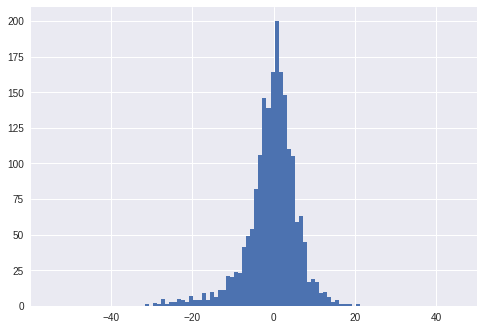

In [0]:
import matplotlib.pyplot as plt
plt.hist(err[:,1], bins=np.arange(min(err[:,0]), max(err[:,0]) + 1, 1))
plt.show()

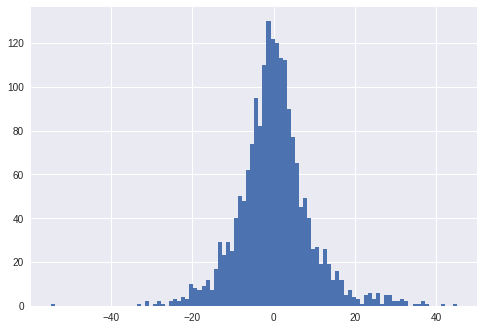

In [0]:
import matplotlib.pyplot as plt
plt.hist(err[:,0], bins=np.arange(min(err[:,0]), max(err[:,0]) + 1, 1))
plt.show()

In [0]:
print(model.to_json())

{"class_name": "Sequential", "config": {"name": "sequential_7", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_37", "trainable": true, "batch_input_shape": [null, 48, 640, 1], "dtype": "float32", "filters": 4, "kernel_size": [3, 4], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_55", "trainable": true, "axis": -1, "momentum": 0.99, "epsilon": 0.001, "center": true, "scale": true, "beta_initializer": {"class_name": "Zeros", "config": {}}, "gamma_initializer": {"class_name": "

In [0]:
import matplotlib.pyplot as plt
plt.hist(y_test[:,1], bins=np.arange(min(y_test[:,1]), max(y_test[:,1]) + 1, 1))
plt.show()

In [0]:
model.summary()

In [0]:
import random
k = []
for i in range(10):
  k.append(random.randint(1,1200))

In [0]:
print(k)

[868, 76, 598, 948, 652, 428, 1069, 961, 531, 675]


In [0]:
xx = []
for i in k:
  xx.append(x_test[i])

In [0]:
import numpy as np
xx = np.asarray(xx)

In [0]:
yy = model.predict(xx)

In [0]:
y = []
for i in k:
  y.append(y_test[i])

In [0]:
a = yy-y

In [0]:
y

[array([126.,  67.]),
 array([125.,  66.]),
 array([125.,  71.]),
 array([91., 64.]),
 array([113.,  62.]),
 array([91., 65.]),
 array([109.,  63.]),
 array([107.,  65.]),
 array([137.,  72.]),
 array([128.,  61.])]

In [0]:
a = [1,2,6,-9,8,-2,-2,3,1,-1]
b = [1,3,-7,-4,2,5,-1,4,-2,2]

In [0]:
np.mean(np.absolute(b))

3.1

In [0]:
import matplotlib.pyplot as plt
plt.hist(b, bins=np.arange(-10, 10 + 1, 1))
plt.show()

In [0]:
import pickle

a = pickle.load(open('/content/v02/history02.pickle', 'rb'))

In [0]:
a.history

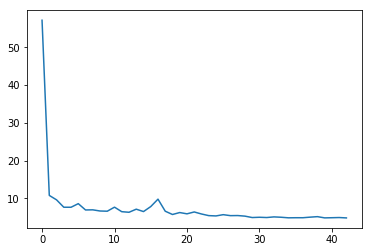

In [0]:
plt.plot(a.history['val_mean_absolute_error'])
plt.show()

In [0]:
import numpy as np
f = np.load('/content/f1.npy')

In [0]:
data = inp.reshape((1,48,640,1))

In [14]:
model.predict(data)

array([[-1094.746   ,    42.424732]], dtype=float32)